#  ATOC5860 Application Lab #5 - synthetic data_with_filters
##### Written by Prof. Barnes (CSU) with additional commenting by Prof. Kay (CU) and Prof. Maroon (UWisc)
##### last updated April 17, 2023 - works with environment atoc5860env2023clean.yml


### LEARNING GOALS:
1) Apply both non-recursive and recursive filters to a synthetic dataset
2) Contrast the influence of applying different non-recursive filters including the 1-2-1 filter, 1-1-1 filter, the 1-1-1-1-1 filter, and the Lanczos filter.
3) Investigate the influence of changing the window and cutoff on Lanczos smoothing.

### DATA and UNDERLYING SCIENCE MOTIVATION:  

In this notebook, you analyze a timeseries with known properties.  You will apply filters of different types and assess their influence on the resulting filtered dataset.

**Questions to guide your analysis** 

1) Create a red noise timeseries with oscillations. Plot your synthetic data – Look at your data!!  Look at the underlying equation. What type of frequencies might you expect to be able to remove with filtering?  

2) Apply non-recursive filters in the time domain (i.e., apply a moving average to the original data) to reduce power at high frequencies.  Compare the filtered time series with the original data (top plot).  Look at the moving window weights (bottom plot).   You are using the function “filtfilt” from scipy.signal, which applies both a forward and a backward running average.  Try different filter types – What is the influence of the length of the smoothing window or weighted average that is applied (e.g., 1-1-1 filter vs. 1-1-1-1-1 filter)?  What is the influence of the amplitude of the smoothing window or the weighted average that is applied (e.g., 1-1-1 filter vs. 1-2-1 filter)?  Tinker with different filters and see what the impact is on the filtering that you obtain.

3) Apply a Lanczos filter to remove high frequency noise (i.e., to smooth the data).  What is the influence of increasing/decreasing the window length on the smoothing and the response function (Moving Window Weights) in the Lanczos filter?  What is the influence of increasing/decreasing the cutoff on the smoothing and the response function?

4) Apply a Butterworth filter, a recursive filter.  Compare the response function (Moving Window Weights) with the non-recursive filters analyzed above.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy.signal as sig
from matplotlib.gridspec import GridSpec
import timeit
import scipy.io as sio

0.5


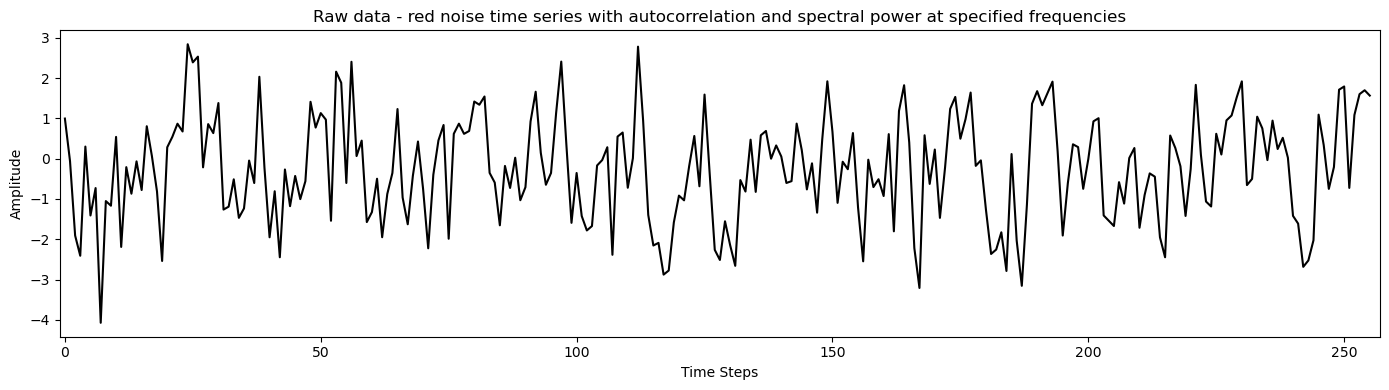

In [3]:
# generate an anomaly red noise time series with oscillations
n = 256              ## number of time steps
alpha = 0.5          ## autocorrelation
freq = 128./256.      ## oscillation frequency
freq2 = 64./256     ## oscillation frequency 2
print(freq)
factor = np.sqrt(1.-alpha*alpha)
x = np.zeros((n,))
pnum = 0
x[0] = x[-1]*alpha + factor*np.random.randn()
for j in np.arange(1,n):
    x[j] = x[j-1]*alpha + factor*np.random.randn()+1.0*np.cos(2.0*np.pi*(1.-0.01*np.random.randn())*freq*j) + \
    0.75*np.cos(2.*np.pi*(1.-.001*np.random.randn())*freq2*j-np.pi/4.) 
# remove the mean - calculate the anomaly    
xa = x - np.mean(x) 

f=plt.figure(figsize=(14,4))
plt.plot(x,'-k',linewidth = 1.5, label = 'raw input');
plt.xlim(-1,np.size(x)+1);
plt.title('Raw data - red noise time series with autocorrelation and spectral power at specified frequencies');
plt.xlabel('Time Steps');
plt.ylabel('Amplitude');
f.tight_layout()

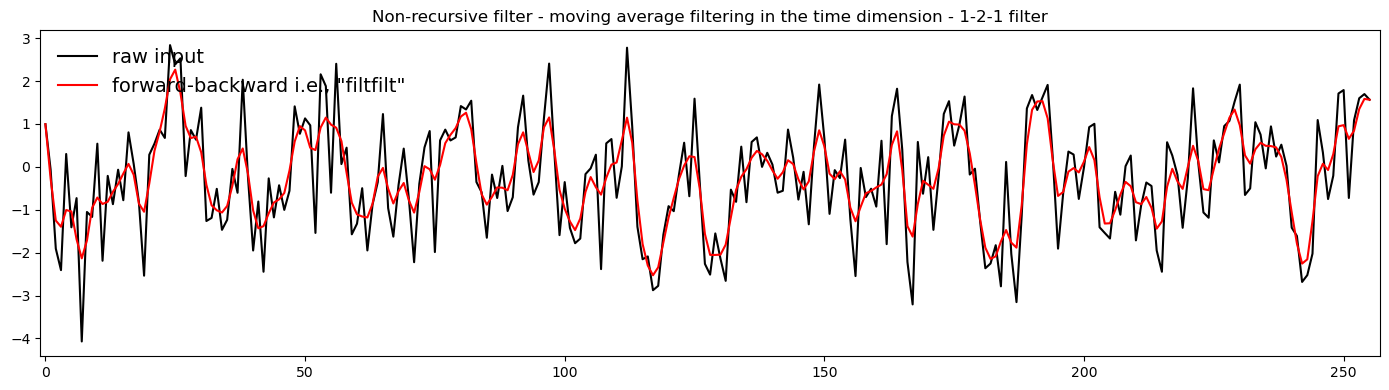

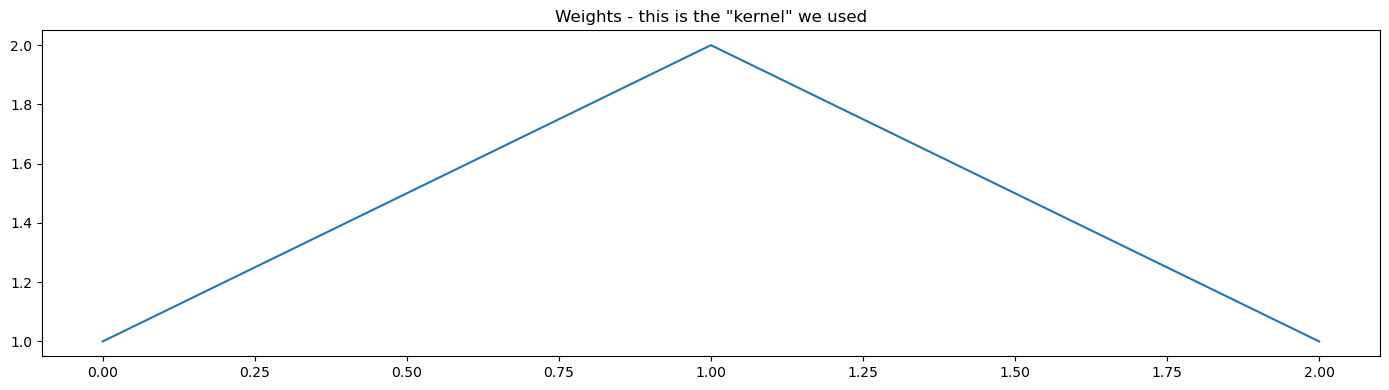

In [4]:
### Apply a non-recursive filter in the time dimension.  Note: this filter is also called a moving average filter
### Try multiple non-recursive filter types

### Type #1: Apply a 1-2-1 filter (filtering in the time dimension, non-recursive moving average filter)
f=plt.figure(figsize=(14,4))
plt.plot(x,'-k',linewidth = 1.5, label = 'raw input');
b = (1,2,1)
y = sig.filtfilt(b,np.sum(b),x) ## applying the moving average to the data  (numerator, denomenator, data)
plt.plot(y,'-r', label = 'forward-backward i.e., "filtfilt"')
plt.xlim(-1,np.size(x)+1)
plt.legend(frameon = False, fontsize = 14,loc='upper left')
plt.title('Non-recursive filter - moving average filtering in the time dimension - 1-2-1 filter')
f.tight_layout()

f=plt.figure(figsize=(14,4))
plt.plot(b);
plt.title('Weights - this is the "kernel" we used')
f.tight_layout()

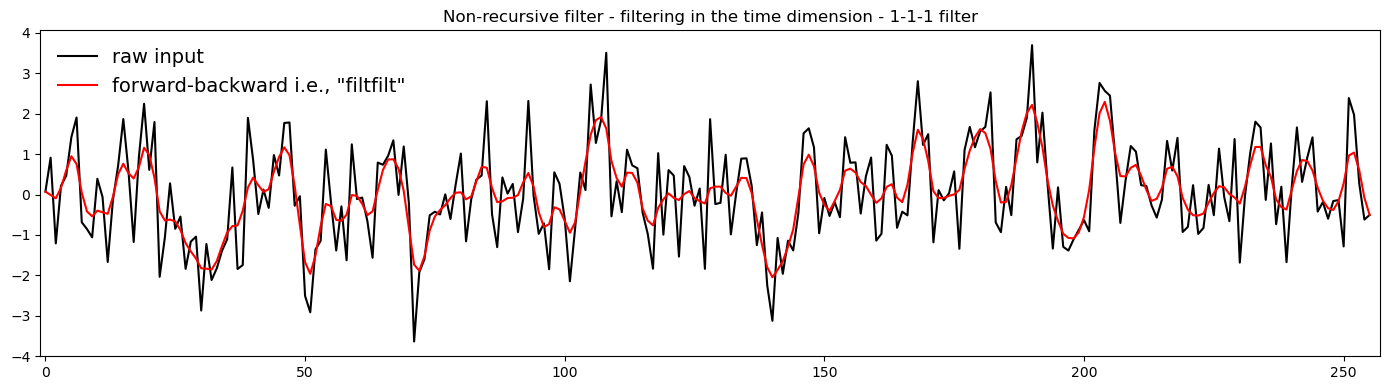

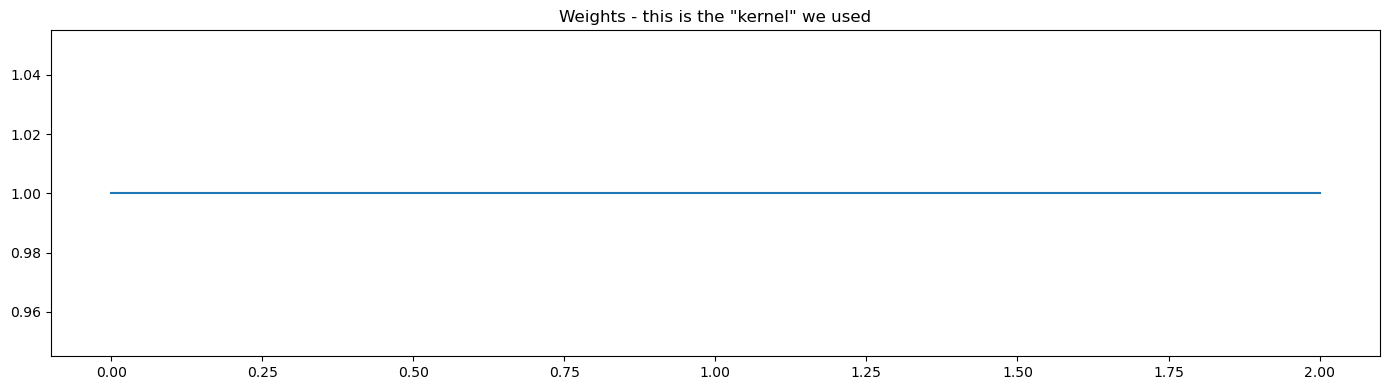

In [4]:
### Type #2: Apply a 1-1-1 filter, Another example of a non-recursive moving average filter in the time dimension
f=plt.figure(figsize=(14,4))
plt.plot(x,'-k',linewidth = 1.5, label = 'raw input');
b = (1,1,1)
y = sig.filtfilt(b,np.sum(b),x) ## applying the moving average to the data  (numerator, denomenator, data)
plt.plot(y,'-r', label = 'forward-backward i.e., "filtfilt"')
plt.xlim(-1,np.size(x)+1)
plt.legend(frameon = False, fontsize = 14,loc='upper left')
plt.title('Non-recursive filter - filtering in the time dimension - 1-1-1 filter')
f.tight_layout()

f=plt.figure(figsize=(14,4))
plt.plot(b);
plt.title('Weights - this is the "kernel" we used')
f.tight_layout()

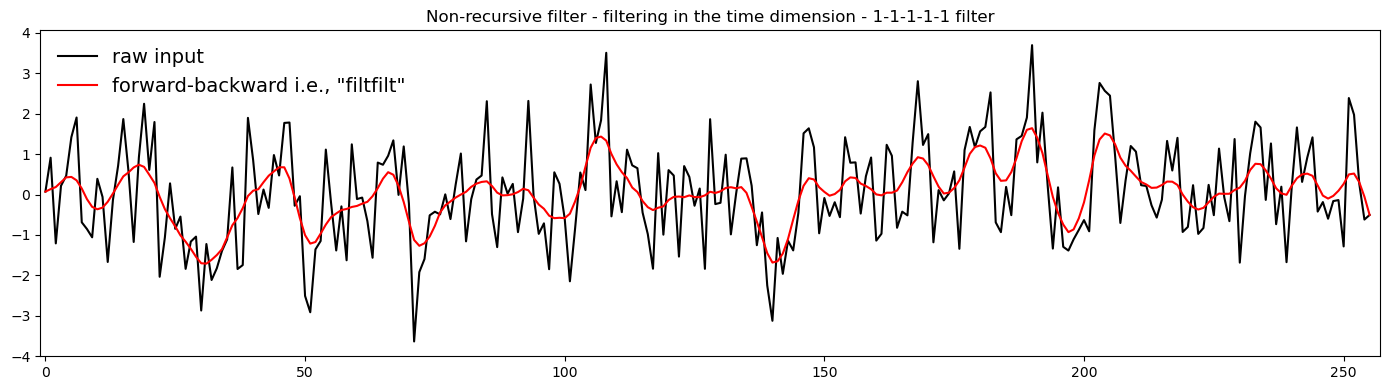

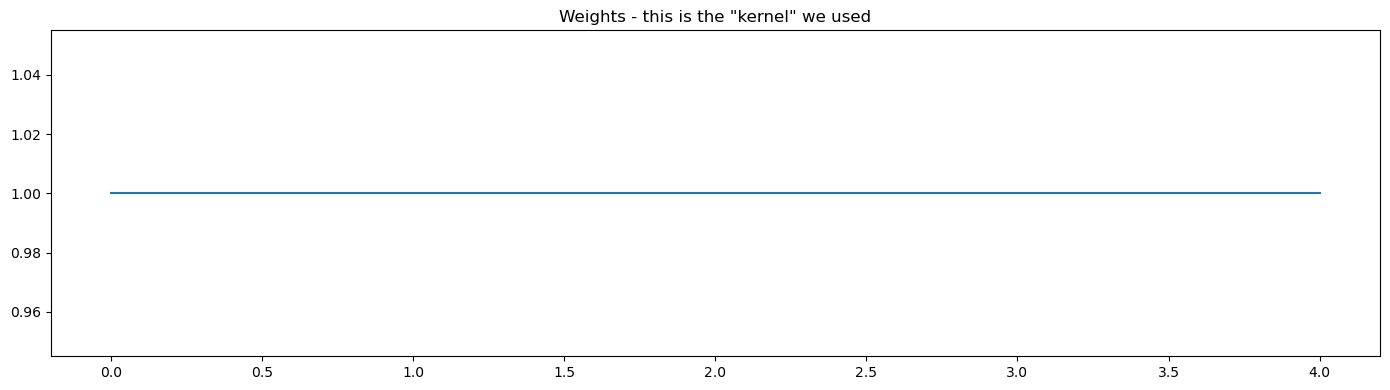

In [5]:
### Type #3: Apply a 1-1-1-1-1 filter... yet another example of a non-recursive moving average filter in the time dimension
f=plt.figure(figsize=(14,4))
plt.plot(x,'-k',linewidth = 1.5, label = 'raw input');
b = (1,1,1,1,1)
y = sig.filtfilt(b,np.sum(b),x) ## applying the moving average to the data  (numerator, denomenator, data)
plt.plot(y,'-r', label = 'forward-backward i.e., "filtfilt"')
plt.xlim(-1,np.size(x)+1)
plt.legend(frameon = False, fontsize = 14,loc='upper left')
plt.title('Non-recursive filter - filtering in the time dimension - 1-1-1-1-1 filter')
f.tight_layout()

f=plt.figure(figsize=(14,4))
plt.plot(b);
plt.title('Weights - this is the "kernel" we used')
f.tight_layout()

oscillation frequency synthetic data (per timestep): 0.203125
frequency cutoff (per timestep): 0.09090909090909091


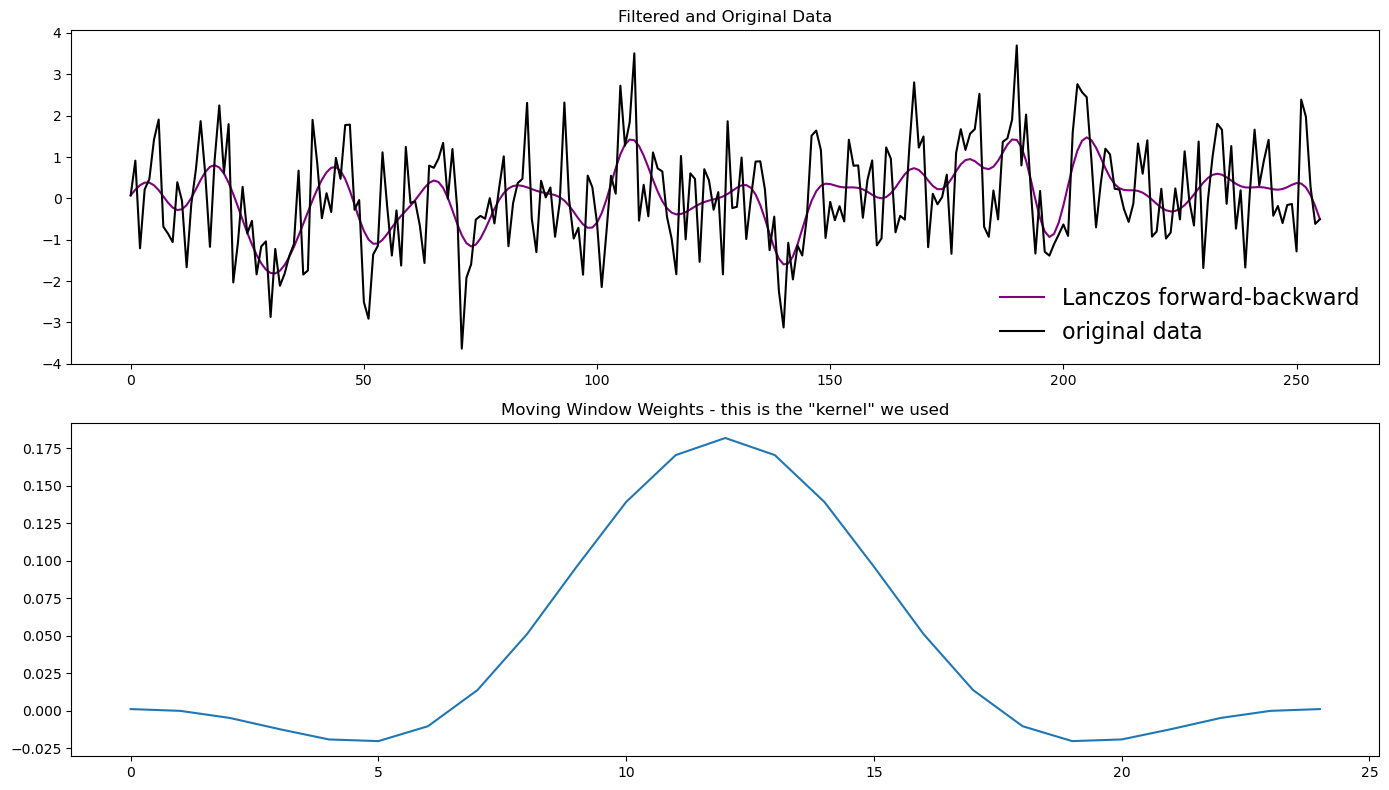

In [6]:
### Type #4 -- Lanczos Filter (non-recursive)
### Let's apply a very standard non-recursive filter called the Lanczos Filter in the time dimension

### Function to make window for Lanczos Filter
def low_pass_weights(window, cutoff):
    """Calculate weights for a low pass Lanczos filter.
    Args:
    window: int
        The length of the filter window in time steps
    cutoff: float
        The cutoff frequency in inverse time steps. 
        (e.g., for data collected every hour, frequency units are per hour)
    """
    order = ((window - 1) // 2 ) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k) 
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma    
    return w[1:-1]

# specify the window length for filters
window = 25 ## (default 25) 
cutoff = 1. / 11. ## (default 1./11.)
wgts24 = low_pass_weights(window, cutoff)
print('oscillation frequency synthetic data (per timestep): '+str(freq))
print('frequency cutoff (per timestep): '+str(cutoff))

f=plt.figure(figsize=(14,8))
gs=GridSpec(2,1)
fig=plt.subplot(gs[0,0])
y = sig.filtfilt(wgts24,np.sum(wgts24),x)
plt.plot(y, color = 'purple', label = 'Lanczos forward-backward');
plt.plot(x,'-k',linewidth = 1.5, label = 'original data');
plt.title('Filtered and Original Data')
plt.legend(frameon = False, fontsize = 16);
fig=plt.subplot(gs[1,0])
plt.plot(wgts24);
plt.title('Moving Window Weights - this is the "kernel" we used')
f.tight_layout()

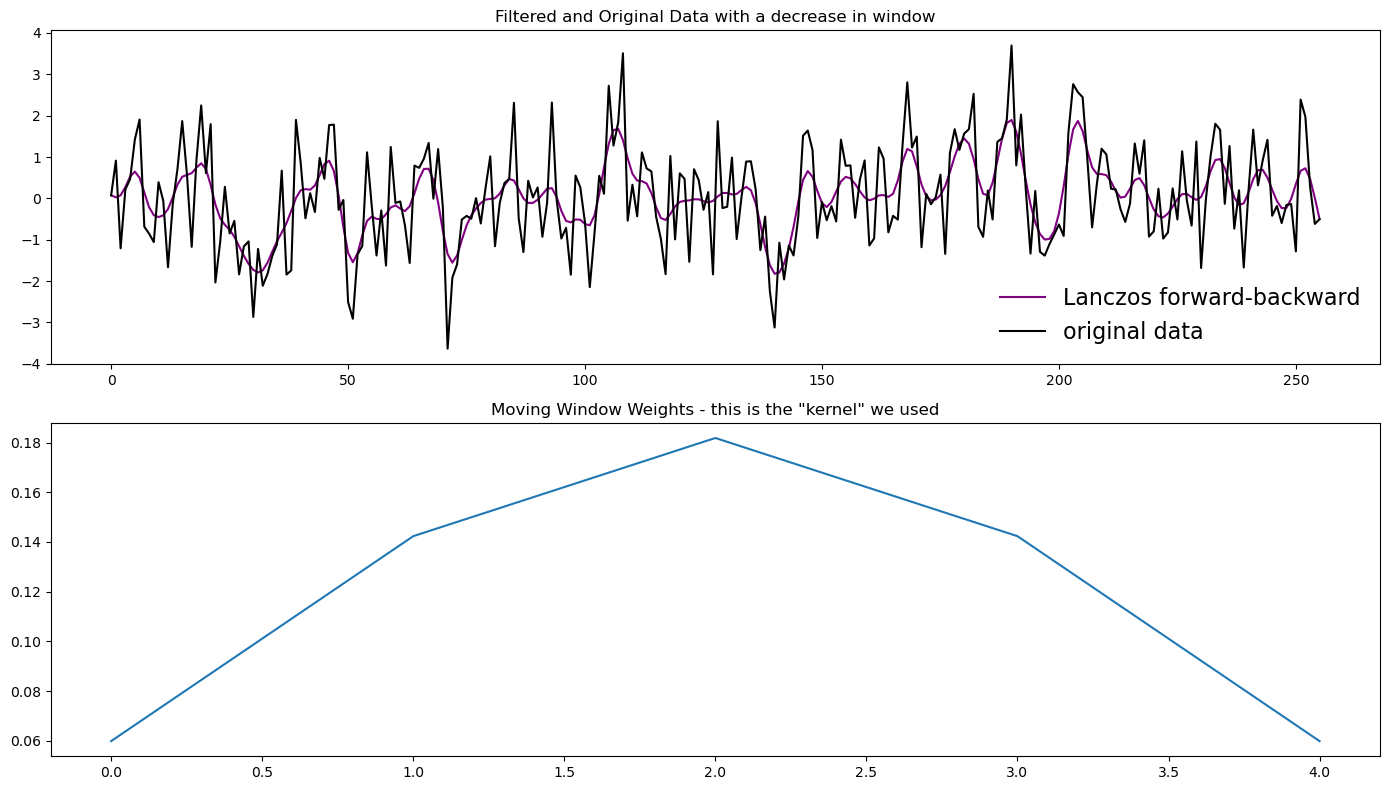

In [7]:
# NOW try changing the window length for filters
window = 5 ## if you decrease window (5), you get less smoothing.  if you increase window (50), you get more smoothing.  
cutoff = 1. / 11. ## (default 1./11.)
wgts24 = low_pass_weights(window, cutoff)

f=plt.figure(figsize=(14,8))
gs=GridSpec(2,1)
fig=plt.subplot(gs[0,0])
y = sig.filtfilt(wgts24,np.sum(wgts24),x)
plt.plot(y, color = 'purple', label = 'Lanczos forward-backward');
plt.plot(x,'-k',linewidth = 1.5, label = 'original data');
plt.title('Filtered and Original Data with a decrease in window')
plt.legend(frameon = False, fontsize = 16);
fig=plt.subplot(gs[1,0])
plt.plot(wgts24);
plt.title('Moving Window Weights - this is the "kernel" we used')
f.tight_layout()

oscillation frequency synthetic data: 0.203125
frequency cutoff: 0.11


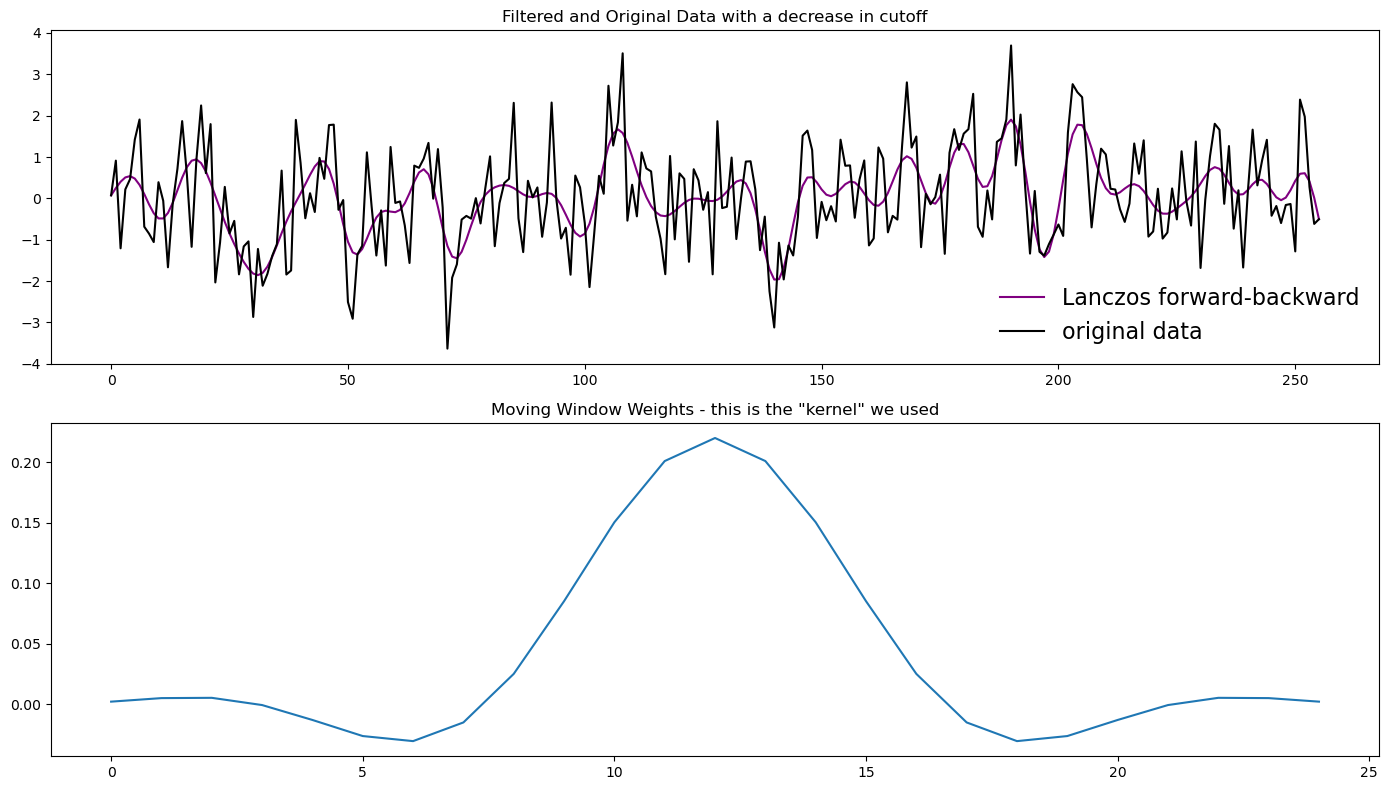

In [8]:
# NOW try changing the window length for filters
window = 25 ## default 25
cutoff = 11. / 100. ## if you increase cutoff, weights concentrated in the middle of the window
                    ## if you decrease cutoff, more weight concentrated at the end of the window
wgts24 = low_pass_weights(window, cutoff)

print('oscillation frequency synthetic data: '+str(freq))
print('frequency cutoff: '+str(cutoff))

f=plt.figure(figsize=(14,8))
gs=GridSpec(2,1)
fig=plt.subplot(gs[0,0])
y = sig.filtfilt(wgts24,np.sum(wgts24),x)
plt.plot(y, color = 'purple', label = 'Lanczos forward-backward');
plt.plot(x,'-k',linewidth = 1.5, label = 'original data');
plt.title('Filtered and Original Data with a decrease in cutoff')
plt.legend(frameon = False, fontsize = 16);
fig=plt.subplot(gs[1,0])
plt.plot(wgts24);
plt.title('Moving Window Weights - this is the "kernel" we used')
f.tight_layout()

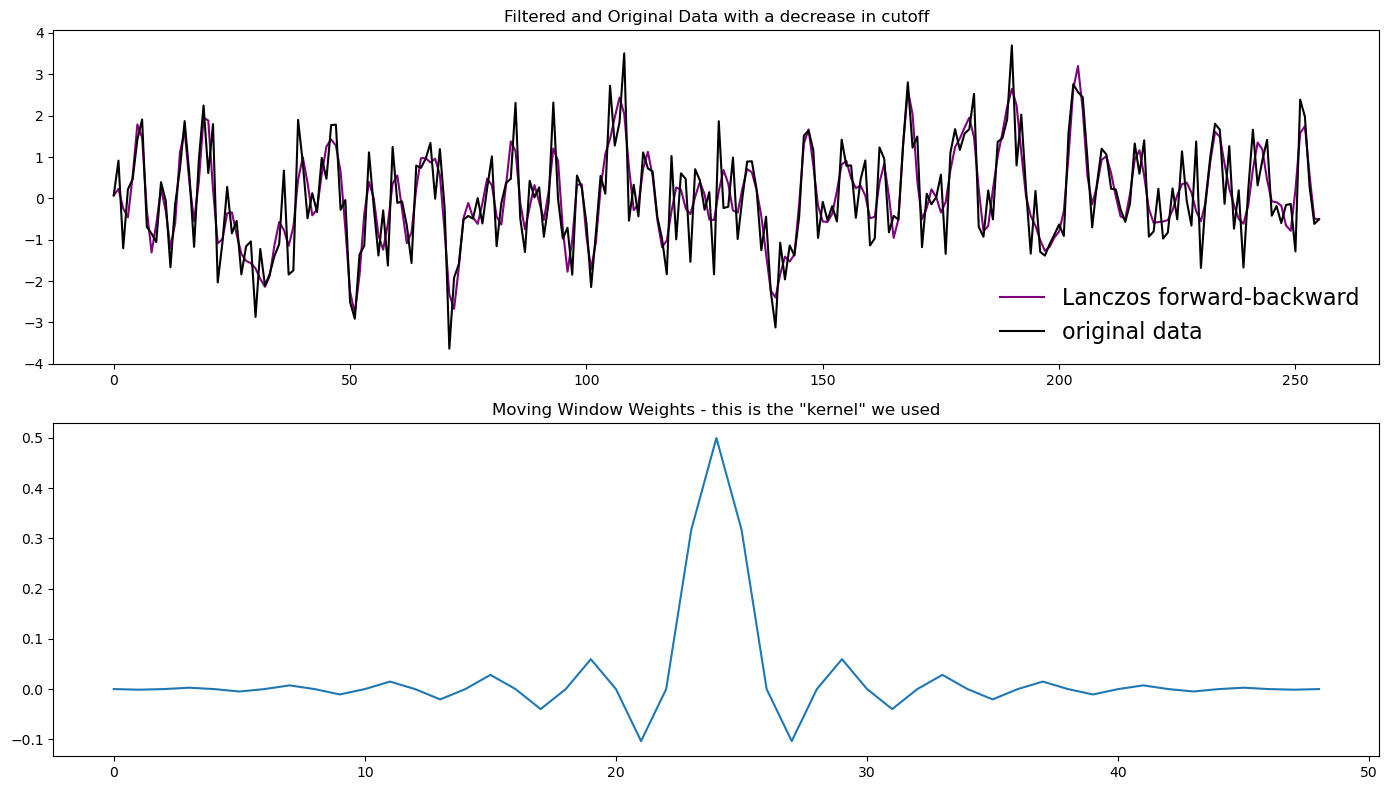

In [9]:
## NOW try changing the window length for filters at different frequencies
### With a lower cutoff frequency = the window length has a bigger influence on the amount of smoothing

window = 50 ## if you decrease the window, you get less smoothing.
cutoff = 25. / 100. ## if you increase cutoff, weights concentrated in the middle of the window
wgts24 = low_pass_weights(window, cutoff)

f=plt.figure(figsize=(14,8))
gs=GridSpec(2,1)
fig=plt.subplot(gs[0,0])
y = sig.filtfilt(wgts24,np.sum(wgts24),x)
plt.plot(y, color = 'purple', label = 'Lanczos forward-backward');
plt.plot(x,'-k',linewidth = 1.5, label = 'original data');
plt.title('Filtered and Original Data with a decrease in cutoff')
plt.legend(frameon = False, fontsize = 16);
fig=plt.subplot(gs[1,0])
plt.plot(wgts24);
plt.title('Moving Window Weights - this is the "kernel" we used')
f.tight_layout()

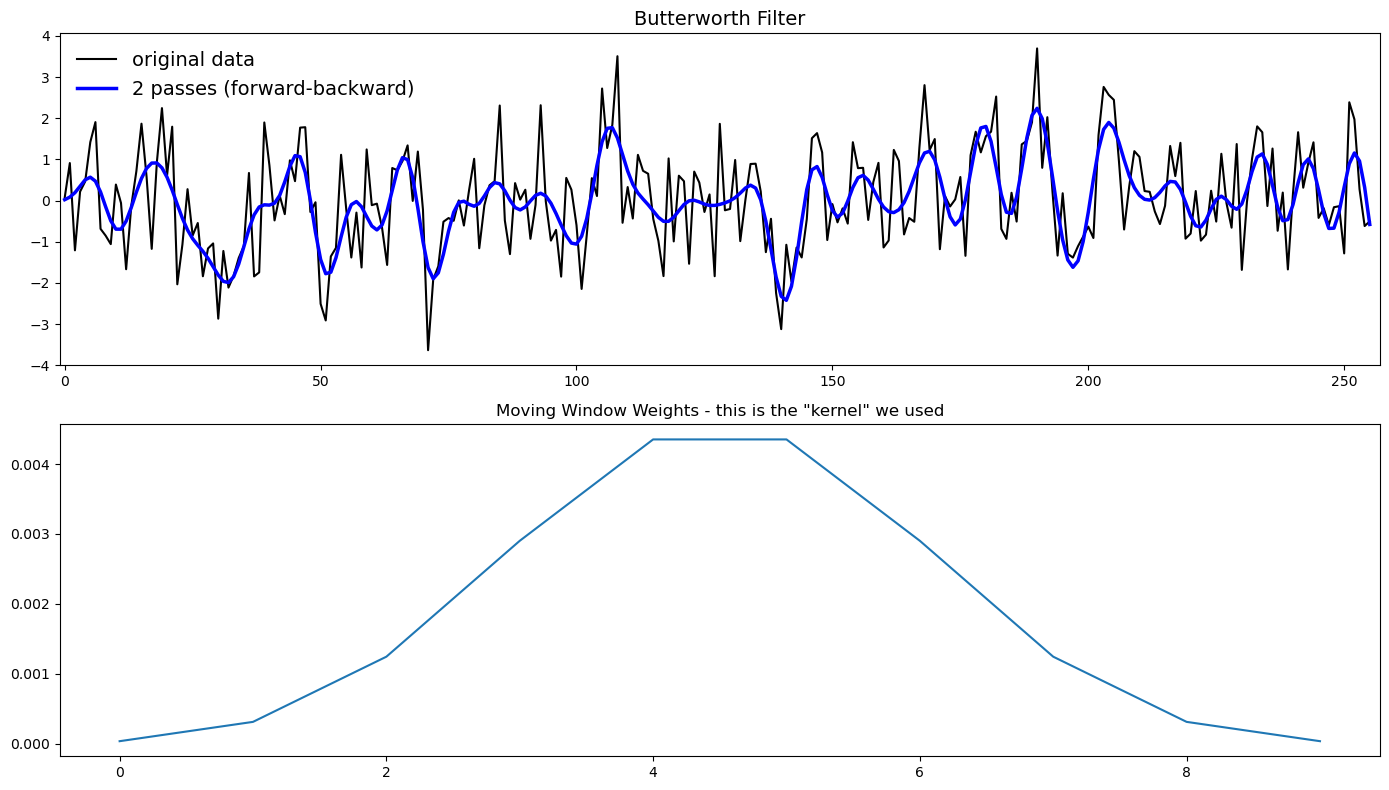

In [10]:
### Compare above to a recursive filter...

### Butterworth filter of actual data (recursive filter)
N = 9 ## order
Wn = 0.25 ## scalar given the critical frequency (all higher frequencies are removed)
## Note: Wn is normalized from 0 to 1, where 1 is the Nyquist frequency, pi radians/sample. 
## Note: (Wn is thus in half-cycles / sample.) 

b, a = sig.butter(N, Wn)
y = sig.filtfilt(b,a,xa) ## one filter forward, one filter backward - you are filtering twice

f=plt.figure(figsize=(14,8))
gs=GridSpec(2,1)
fig=plt.subplot(gs[0,0])
plt.plot(x,'-k',linewidth = 1.5, label = 'original data');
plt.plot(y,'-b',linewidth = 2.5, label = '2 passes (forward-backward)');
plt.title('Butterworth Filter',fontsize=14)
plt.legend(frameon = False,fontsize = 14,loc='upper left')
plt.xlim(-1,np.size(x)+1)
fig=plt.subplot(gs[1,0])
plt.plot(b);
plt.title('Moving Window Weights - this is the "kernel" we used')
f.tight_layout()